# Covid19 Tweets Data Exploration
The results of this data analysis are discussed in this [medium article](https://medium.com/@spambeantworter/tweetscov19-what-moved-the-world-when-the-pandemic-started-cac4518d13f7)

## Business & Data Understanding
How do twitter tweets reflect what concerned us during the outbreak of Covid-19?  
Researchers of GESIS — Leibniz-Institute for the Social Sciences in Mannheim, Germany compiled a [dataset of more than 8 million tweets](https://data.gesis.org/tweetscov19/) related to Covid-19 that were twitterd between October 2019 and April 2020.  
Covid related tweets were identified by a list of keywords that had to appear in the tweets text.
The topics disussed in the tweets are pre-analyzed by the researchers and encoded as entities.

A sentiment is pre-annotated in this dataset by a positive and a negative sentiment score between 1 and 5, representing the positivity and negativity of the tweet.

The dataset contains more information, like mentions and hashtags, that were not analysed in this project.

## Imports

In [3]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import unquote
from scipy.stats import pearsonr
from tqdm import tqdm

%matplotlib inline
sns.set_context("talk")
figsize = (15,5)

## Data Preparation
Set the correct filenames and paths to the input data file (download first)
* `TweetsCOV19_file` from https://data.gesis.org/tweetscov19

In [2]:
TweetsCOV19_file = "../data/tweetsCov19/TweetsCOV19.tsv"

In [3]:
%%time
# load Tweets Covid-19 data (~45 min. to 1 hour, due to slow timestamp conversion. Comment out converter for MUCH faster read)
colnames = ["TweetID", "Username", "date", "Followers", "Friends", "Retweets", "Favorites", "Entities", "Sentiment", "Mentions", "Hashtags", "URLs"]
df = pd.read_csv(TweetsCOV19_file, sep='\t', header=None, names=colnames,
                 na_values=["null;"], converters={"date": pd.Timestamp},
                 nrows=None)
df.set_index("date", drop=True, inplace=True)
print(df.shape)
print(df.index.min(), df.index.max())

(8077794, 11)
2019-09-30 22:00:00+00:00 2020-04-30 21:59:46+00:00
Wall time: 53min 4s


In [4]:
%%time
# separate positive from negative sentiment score
sentiment = df["Sentiment"].apply(lambda s: s.split())
df["Sentiment_positive"] = sentiment.apply(lambda l: int(l[0]))
df["Sentiment_negative"] = sentiment.apply(lambda l: int(l[1]))
df.drop(columns=["Sentiment"], inplace=True)

Wall time: 38.2 s


### Extract entities and add integer columns for entities

In [7]:
# Initialize entity lists to empty lists (~15 sec.)
%time df["Entities_list"] = np.empty((len(df), 0)).tolist()

Wall time: 14.7 s


In [8]:
%%time 
# get a list of all entities (~30 sec.)
nonna = ~df["Entities"].isna()
df.loc[nonna,"Entities_list"] = df["Entities"][nonna].apply(lambda s: [i.split(':')[1] for i in s.split(';')[:-1]])
entities = pd.Series(itertools.chain.from_iterable(df["Entities_list"]))
entities.name = "Entities"

Wall time: 37.6 s


In [9]:
entities_counts = entities.value_counts()
entities_counts_rel = entities_counts / df.shape[0] # dividy by total number of tweets

In [10]:
freq_cutoff_upper = 0.009 # chosen as to remove some uninteresting entities
freq_cutoff_lower = 0.001
frequent_entities = entities_counts_rel[(entities_counts_rel <= freq_cutoff_upper) & (entities_counts_rel >= freq_cutoff_lower)]
frequent_entities.drop("Spotify", inplace=True) # due to strange behaviour (single large peak in December 2019)
print(f"There are {entities_counts.shape[0]} distinct entities in the dataset.")
print(f"Only {frequent_entities.shape[0]} entities appear between {freq_cutoff_lower*100} % and {freq_cutoff_upper*100:.1f} % of all tweets.")

There are 330123 distinct entities in the dataset.
Only 117 entities appear between 0.1 % and 0.9 % of all tweets.


In [11]:
%%time
# add integer column to count entity usage (~20 min.)
for entity in tqdm(frequent_entities.index, desc="Extracting entities to int cols"):
    df[entity] = df["Entities_list"].apply(lambda l: int(entity in l))

Extracting entities to int cols: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [18:24<00:00,  9.44s/it]

Wall time: 18min 24s


### Cache results to disk for quicker restarts

In [5]:
# Save with pickle so it can be read faster next time
%time df.to_pickle("../data/tweetsCov19/TweetsCOV19_df.pkl")

Wall time: 39.8 s


In [23]:
# Save with pickle so it can be read faster next time
%time df.to_pickle("../data/tweetsCov19/TweetsCOV19_df_intent.pkl")

Wall time: 1min 46s


## Data Modeling 
### Resample data to Timeseries of daily sum and mean number of tweets per entity

In [13]:
%time daily_sum = df.resample('D').sum()

Wall time: 1min 44s


In [14]:
%time weekly_sum = df.resample('W').sum()

Wall time: 1min 23s


In [15]:
%time monthly_sum = df.resample('M').sum()

Wall time: 1min 25s


In [16]:
%time daily_mean = df.resample('D').mean()

Wall time: 1min 24s


In [17]:
%time weekly_mean = df.resample('W').mean()

Wall time: 1min 27s


In [18]:
%time monthly_mean = df.resample('M').mean()

Wall time: 1min 25s


## Results and Evaluation

### Entity Analysis

The frequency of entities decays sharply, i.e. there are only few tweets that appear frequently


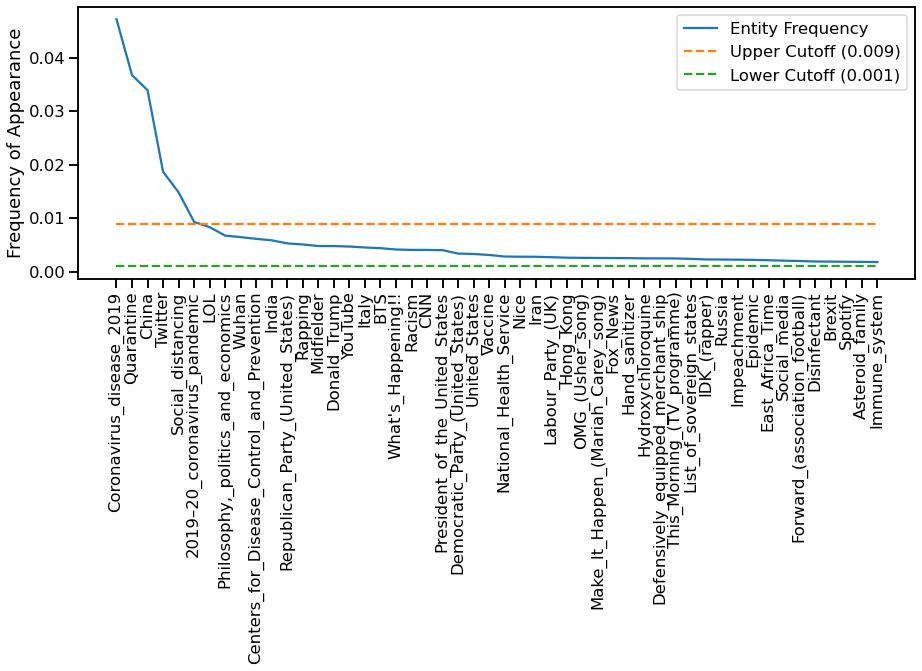

In [12]:
print("The frequency of entities decays sharply, i.e. there are only few tweets that appear frequently")
s = 0  # start index of entity to display
n = 50 # number of entities to display
plt.figure(figsize=figsize)
plt.plot(entities_counts_rel.values[s:n+s], label="Entity Frequency")
plt.plot([0,n-1], 2*[freq_cutoff_upper], "--", label=f"Upper Cutoff ({freq_cutoff_upper})")
plt.plot([0,n-1], 2*[freq_cutoff_lower], "--", label=f"Lower Cutoff ({freq_cutoff_lower})")
plt.xticks(range(n), [unquote(l) for l in entities_counts.index[s:n+s]], rotation=90)
plt.ylabel("Frequency of Appearance")
plt.legend()
plt.savefig("../figures/entity_frequency.png", bbox_inches="tight")

### Entity Usage Over Time

<AxesSubplot:xlabel='date', ylabel='Tweets per Week'>

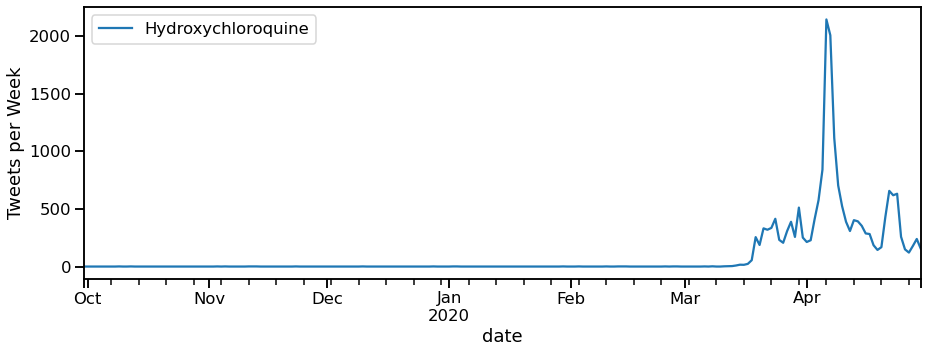

In [19]:
daily_sum[frequent_entities.index[28:29]].plot(figsize=figsize, ylabel="Tweets per Week")

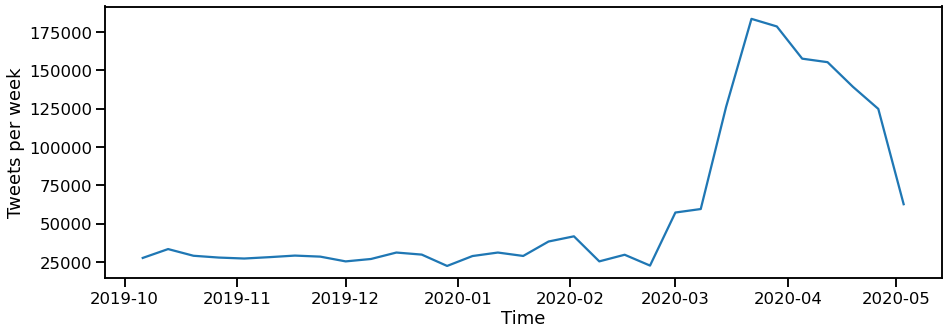

In [20]:
plt.figure(figsize=figsize)
plt.plot(weekly_sum[frequent_entities.index].sum(1))
plt.xlabel("Time")
plt.ylabel("Tweets per week")
plt.savefig("../figures/tweets_per_week.png", bbox_inches="tight")

In [21]:
def normalize_on_period(data, period=None, stdperiod=None, std_only_if_peak=True):
    """
    Normalize data on specified period
    
    period: pandas datetime indexing string for the period that is used for the normalization
    stdperiod: pandas datetime intexing string for the preiod that is used for std computation, defaults to period value
    std_only_if_peak: if true only use stdperiod if the global peak is in this period, otherwise use period
    """
    
    if period is None:
        data_mean = data.mean()
    else:
        data_mean = data[period].mean()
        
    if stdperiod is None:
        data_std = data.std()
    else:
        if not std_only_if_peak:
            data_std = data[stdperiod].std()
        else:
            # if global max falls within stdperiod
            if data[stdperiod].max() == data.max():
                data_std = data[stdperiod].std()
            else:
                if period is None:
                    data_std = data.std()
                else:
                    data_std = data[period].std()
                
    
    data -= data_mean
    data /= data_std
    
    return data


def correlate(series1, series2):
    corr = np.correlate(series1, series2, mode="same")
    corrmax = corr.max()
    corr_offset = (series1.shape[0] // 2) - corr.argmax()
    corrtime    = corr_offset * series1.index.freq
    return corrmax, corrtime


correlations = np.zeros(2*[frequent_entities.shape[0]], dtype=float)
corrtimes    = np.zeros_like(correlations, dtype=pd.Timedelta)
correlations = pd.DataFrame(correlations, index=frequent_entities.index, columns=frequent_entities.index)
corrtimes    = pd.DataFrame(corrtimes,    index=frequent_entities.index, columns=frequent_entities.index)

for entity1 in tqdm(frequent_entities.index):
    series1 = daily_sum[entity1].copy()
    series1 = normalize_on_period(series1, period="2019", stdperiod="2020")
    
    for entity2 in frequent_entities.index:
        series2 = daily_sum[entity2].copy()
        series2 = normalize_on_period(series2, period="2019", stdperiod="2020")
        
        corrmax, corrtime = correlate(series1, series2)
        correlations.loc[entity1, entity2] = corrmax
        corrtimes.loc[entity1, entity2]    = corrtime.delta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [01:52<00:00,  1.04it/s]


### Which entities appear together?

In [22]:
countries = ["Germany", "France", "Italy", "Spain", "Japan", "Taiwan", "Russia",
             "Canada", "South_Korea", "Iran", "Australia", "United_States", "Turkey",
             "Ukraine", "Nigeria", "Lagos", "Hong_Kong", "Nigeria", "Europe", "India",
             "Kashmir", "Pakistan"]

In [26]:
# compute the "togetherness" as the frequency that entity1 appears together with entity2 times the opposite frequency (entity2 together with entity1)
togetherness = np.zeros(2*[frequent_entities.shape[0]], dtype=float)
togetherness = pd.DataFrame(togetherness, index=frequent_entities.index, columns=frequent_entities.index)

for entity1 in tqdm(frequent_entities.index):
    ent1_bool = df[entity1] == 1
    ent1_sum  = df[entity1].sum()
    for entity2 in frequent_entities.index:
        togetherness.loc[entity1, entity2] = (((ent1_bool) & (df[entity2] == 1)).sum()**2 / (ent1_sum * df[entity2].sum()))**0.5

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [20:29<00:00, 10.51s/it]


In [27]:
%time daily_sum_corr = daily_sum[frequent_entities.index].corr()

Wall time: 33 ms


In [28]:
# ~8.5 minutes
%time tweet_corr = df[frequent_entities.index].corr()

Wall time: 12min 8s


In [29]:
# remove countries from togetherness, because we don't care about them
not_country    = [False if i in countries else True for i in togetherness.index]
togetherness   = togetherness.loc[not_country, not_country]
not_country    = [False if i in countries else True for i in tweet_corr.index]
tweet_corr     = tweet_corr.loc[not_country, not_country]
not_country    = [False if i in countries else True for i in daily_sum_corr.index]
daily_sum_corr = daily_sum_corr.loc[not_country, not_country]

In [30]:
print(daily_sum.shape)
print(daily_sum_corr.shape)
daily_sum_corr.head()

(214, 124)
(96, 96)


,LOL,Philosophy%2C_politics_and_economics,Wuhan,Centers_for_Disease_Control_and_Prevention,Republican_Party_%28United_States%29,Rapping,Midfielder,Donald_Trump,YouTube,BTS,...,Florida,Nigga,Panic_buying,Copper,National_Basketball_Association,WhatsApp,Stripper,Chloroquine,ASAP_%28TV_program%29,N95_mask
LOL,1.000000,0.757489,0.621996,0.756937,0.906039,0.465272,0.931248,0.921076,0.934660,0.509481,...,0.861966,0.889952,0.619871,0.446125,0.152881,0.885625,0.062603,0.665873,0.896417,0.780744
Philosophy%2C_politics_and_economics,0.757489,1.000000,0.457380,0.458216,0.652535,0.485894,0.851924,0.694748,0.883373,0.404893,...,0.800617,0.621618,0.129155,0.246715,-0.082266,0.797169,0.006034,0.505490,0.621182,0.769879
Wuhan,0.621996,0.457380,1.000000,0.586729,0.621705,0.187326,0.573026,0.603981,0.610363,0.321613,...,0.567823,0.538594,0.458174,0.340762,0.052039,0.546828,0.010695,0.428414,0.612402,0.508090
Centers_for_Disease_Control_and_Prevention,0.756937,0.458216,0.586729,1.000000,0.761687,0.157721,0.657458,0.829233,0.694599,0.372341,...,0.670893,0.712509,0.705107,0.189662,0.187587,0.630182,-0.096779,0.464935,0.728691,0.567384
Republican_Party_%28United_States%29,0.906039,0.652535,0.621705,0.761687,1.000000,0.351058,0.861508,0.902576,0.853062,0.425971,...,0.787614,0.821324,0.644600,0.426651,0.191891,0.858003,-0.012903,0.715245,0.888283,0.754322


In [31]:
print(df.shape)
print(tweet_corr.shape)
tweet_corr.head()

(8077794, 130)
(96, 96)


,LOL,Philosophy%2C_politics_and_economics,Wuhan,Centers_for_Disease_Control_and_Prevention,Republican_Party_%28United_States%29,Rapping,Midfielder,Donald_Trump,YouTube,BTS,...,Florida,Nigga,Panic_buying,Copper,National_Basketball_Association,WhatsApp,Stripper,Chloroquine,ASAP_%28TV_program%29,N95_mask
LOL,1.000000,-0.005580,-0.004972,-0.003588,-0.002903,0.003214,-0.000933,-0.004579,-0.001410,0.000215,...,-0.001492,0.010445,-0.000467,-0.001042,0.000852,-0.001378,0.004713,-0.001788,-0.000519,-0.001811
Philosophy%2C_politics_and_economics,-0.005580,1.000000,-0.003700,-0.000673,0.003502,-0.005482,0.000222,-0.002178,-0.004075,-0.004231,...,0.000543,-0.002401,-0.001988,-0.002163,-0.002421,-0.000815,-0.002461,-0.002073,0.004235,0.024718
Wuhan,-0.004972,-0.003700,1.000000,0.005891,-0.003841,-0.005370,-0.004238,0.000041,0.002631,-0.003956,...,-0.001828,-0.002054,-0.001887,-0.002375,-0.002174,-0.001454,-0.002470,-0.000934,-0.000909,-0.000951
Centers_for_Disease_Control_and_Prevention,-0.003588,-0.000673,0.005891,1.000000,0.005933,-0.005232,-0.003813,0.007648,-0.000617,-0.003879,...,0.002653,-0.002045,-0.001822,-0.002323,-0.001122,-0.001277,-0.002366,0.002021,0.000619,0.002164
Republican_Party_%28United_States%29,-0.002903,0.003502,-0.003841,0.005933,1.000000,-0.004868,-0.003064,0.015581,-0.002000,-0.003964,...,0.008939,-0.002220,-0.002024,-0.001906,-0.001286,-0.002225,-0.001950,-0.000833,-0.000278,-0.001009


Text(0, 0.5, 'Count (Log Scale)')

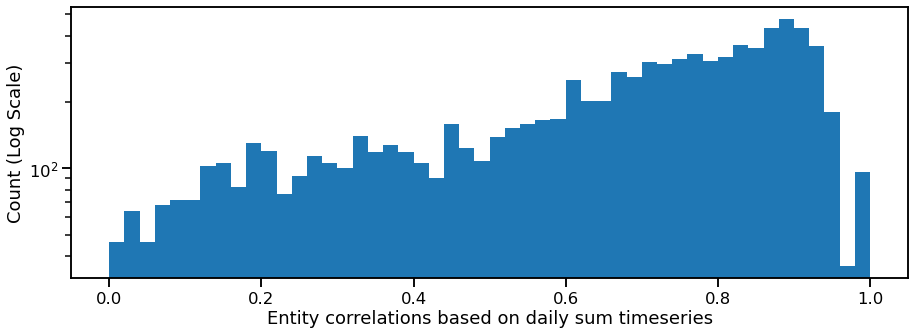

In [32]:
plt.figure(figsize=figsize)
plt.hist(daily_sum_corr.values.flatten(), bins=50, range=(0,1.0), log=True)
plt.xlabel("Entity correlations based on daily sum timeseries")
plt.ylabel("Count (Log Scale)")

Text(0, 0.5, 'Count (Log Scale)')

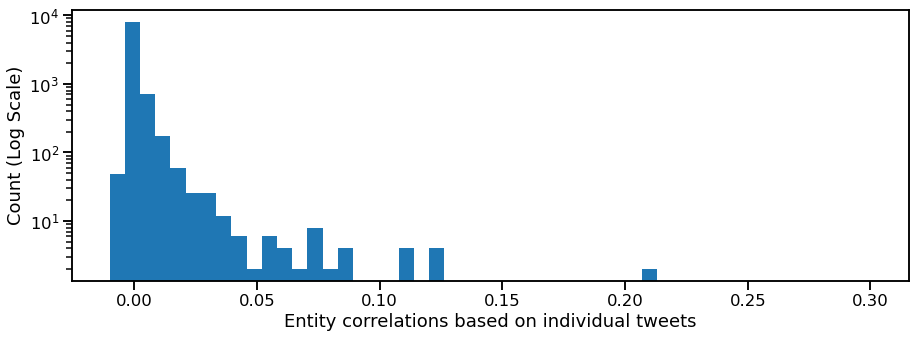

In [33]:
plt.figure(figsize=figsize)
plt.hist(tweet_corr.values.flatten(), bins=50, range=(-0.01,0.3), log=True)
plt.xlabel("Entity correlations based on individual tweets")
plt.ylabel("Count (Log Scale)")

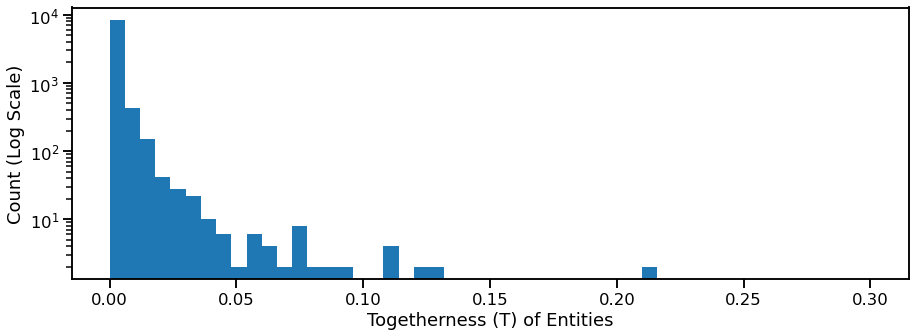

In [34]:
plt.figure(figsize=figsize)
plt.hist(togetherness.values.flatten(), bins=50, range=(0,0.3), log=True)
plt.xlabel("Togetherness (T) of Entities")
plt.ylabel("Count (Log Scale)")
plt.savefig("../figures/togetherness_histogram.png", bbox_inches="tight")

In [35]:
def print_corr(corr, entity1, entity2):
    print(f"T({entity1},{entity2}) = {corr.loc[entity1,entity2]:.2f}")

print_corr(togetherness, "Bill_Gates", "5G")
print_corr(togetherness, "Bill_Gates", "Vaccine")
print_corr(togetherness, "Toilet_paper", "Panic_buying")
print_corr(togetherness, "President_of_the_United_States", "Men_who_have_sex_with_men")
print_corr(togetherness, "President_of_the_United_States", "Fake_news")
print_corr(togetherness, "Donald_Trump", "Men_who_have_sex_with_men")
print_corr(togetherness, "Donald_Trump", "Fake_news")

T(Bill_Gates,5G) = 0.02
T(Bill_Gates,Vaccine) = 0.11
T(Toilet_paper,Panic_buying) = 0.08
T(President_of_the_United_States,Men_who_have_sex_with_men) = 0.03
T(President_of_the_United_States,Fake_news) = 0.01
T(Donald_Trump,Men_who_have_sex_with_men) = 0.02
T(Donald_Trump,Fake_news) = 0.02


In [36]:
upper_limit = 0.9
lower_limit = 0.01
pairs = list(zip(*np.where((togetherness > lower_limit) & (togetherness < upper_limit))))
pairs = set([tuple(sorted(list(p))) for p in pairs])
pairs = [(togetherness.index[p[0]], togetherness.index[p[1]]) for p in pairs]

pairs = pd.DataFrame(pairs, columns=["entity1", "entity2"])
pairs["togetherness"] = pairs.apply(lambda row: togetherness.loc[row.entity1, row.entity2], axis=1)

# remove pairs that are both cuntries and sort by togetherness
pairs = pairs[~pairs.apply(lambda row: (row.entity1 in countries) & (row.entity2 in countries), axis=1)]
pairs.sort_values("togetherness", inplace=True, ascending=False)
pairs.reset_index(inplace=True, drop=True)

with pd.option_context('display.max_rows', pairs.shape[0]):
    display(pairs)

,entity1,entity2,togetherness
0,CNN,MSNBC,0.211103
1,BTS,Jungkook,0.126986
2,Wuhan,Labour_Party_%28UK%29,0.123601
3,Vaccine,Bill_Gates,0.112697
4,Philosophy%2C_politics_and_economics,National_Health_Service,0.111709
5,National_Health_Service,Frontline_%28American_TV_program%29,0.090261
6,Hydroxychloroquine,Chloroquine,0.086884
7,Hand_sanitizer,Toilet_paper,0.082808
8,Toilet_paper,Panic_buying,0.077226
9,CNN,Fox_News,0.075521


In [37]:
def plot_daily_sum(entitylists=None, plotname=None):
    plt.figure(figsize=figsize)
    for entities in entitylists:
        plt.plot(daily_sum[entities].sum(1), label=f"{entities}")
    plt.xlabel("Date")
    plt.ylabel("Daily Number of Tweets")
    plt.legend()
    
    if plotname is not None:
        plt.savefig(f"../figures/{plotname}", bbox_inches="tight")

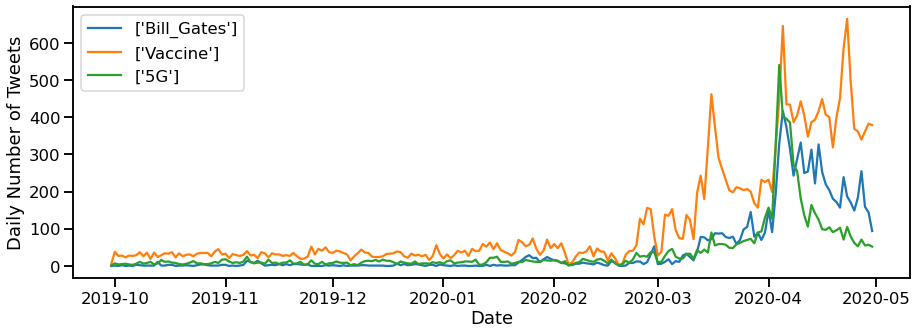

In [38]:
entities1 = ["Bill_Gates"]
entities2 = ["Vaccine"]
entities3 = ["5G"]
plot_daily_sum((entities1, entities2, entities3), "time_evolution_bill_gates_vaccine_5g.png")

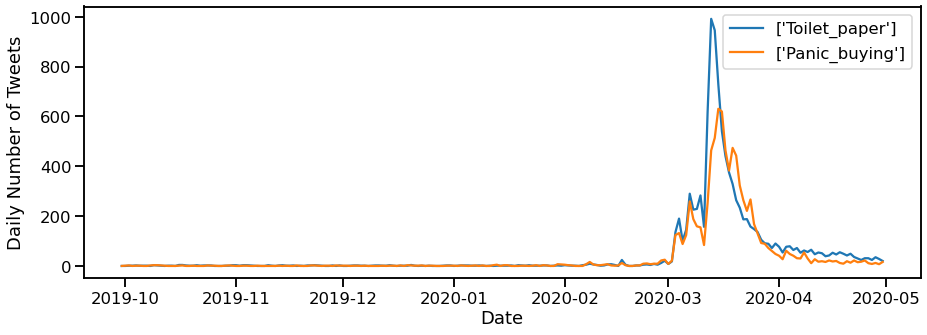

In [39]:
entities1 = ["Toilet_paper"]
entities2 = ["Panic_buying"]
plot_daily_sum((entities1, entities2), "time_evolution_toilet_paper_panic_buying.png")

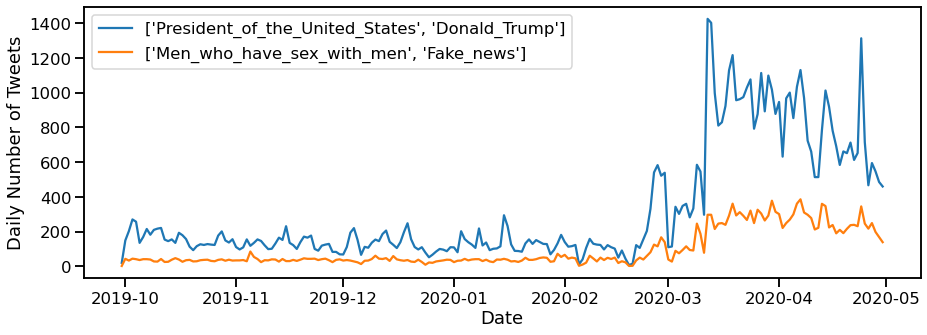

In [40]:
entities1 = ["President_of_the_United_States", "Donald_Trump"]
entities2 = ["Men_who_have_sex_with_men", "Fake_news"]
plot_daily_sum((entities1, entities2), "time_evolution_president_msm_fake_news.png")

### Average sentiment by entity

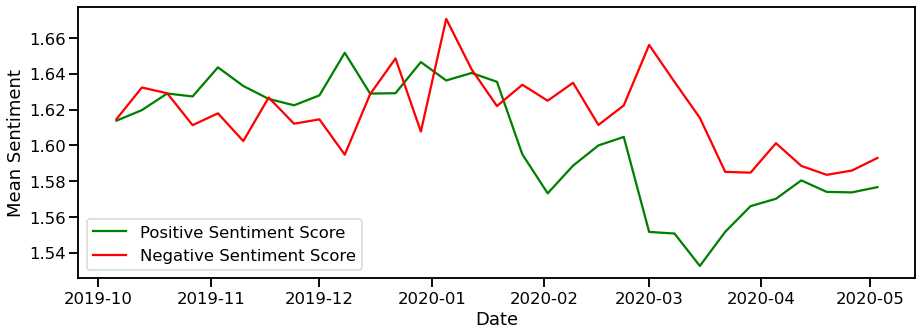

In [41]:
weekly_mean_sentiment = weekly_mean[["Sentiment_positive", "Sentiment_negative"]].abs()
plt.figure(figsize=figsize)
plt.plot(weekly_mean_sentiment["Sentiment_positive"], "g", label="Positive Sentiment Score")
plt.plot(weekly_mean_sentiment["Sentiment_negative"], "r", label="Negative Sentiment Score")
plt.ylabel("Mean Sentiment")
plt.xlabel("Date")
plt.legend()
plt.savefig(f"../figures/weekly_mean_sentiment.png", bbox_inches="tight")

In [42]:
sentiments_by_entity = []
for entity in tqdm(frequent_entities.index, desc="Extracting entities in int cols"):
    positive = df.loc[df[entity] == 1, "Sentiment_positive"].mean()
    negative = df.loc[df[entity] == 1, "Sentiment_negative"].mean()
    sentiments_by_entity.append(pd.Series([positive, negative], ["positive", "negative"], name=entity))
sentiments_by_entity = pd.DataFrame(sentiments_by_entity)

Extracting entities in int cols: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.67it/s]


In [43]:
sentiments_by_entity.sort_values("positive", ascending=False).head(20)

,positive,negative
Amazon_%28company%29,3.051854,-1.518630
Nice,2.281665,-1.596103
Haha_%28entertainer%29,2.237073,-1.597756
OMG_%28Usher_song%29,2.231914,-1.625899
LOL,2.166651,-1.597885
Jungkook,1.951852,-1.457558
Allah,1.879637,-1.852729
BTS,1.871511,-1.434534
Master_of_Arts,1.848345,-1.863741
My_Family,1.834491,-1.876162


In [44]:
sentiments_by_entity.sort_values("negative", ascending=True).head(20)

,positive,negative
Lied,1.501133,-3.148806
Panic_buying,1.479470,-3.107164
Anxiety,1.691885,-2.803678
Fake_news,1.542873,-2.484685
Men_who_have_sex_with_men,1.641151,-2.243009
Hindus,1.594626,-2.226794
Racism,1.552989,-2.187853
Defensively_equipped_merchant_ship,1.627961,-2.126919
Propaganda,1.554492,-2.111587
Bharatiya_Janata_Party,1.526721,-2.012887


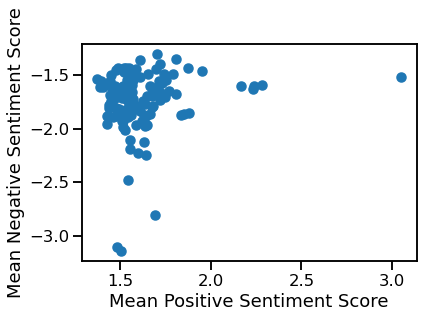

In [45]:
plt.scatter(sentiments_by_entity["positive"], sentiments_by_entity["negative"])
plt.xlabel("Mean Positive Sentiment Score")
plt.ylabel("Mean Negative Sentiment Score");